# Convolutional neural network
In this notebook, you will program the forward step of  convolution and max pooling layers. These layers are one of the basic elements needed to build a complete deep convolutional network.

## Padding

The padding is needed to keep the same image size through convolutions. It simply consist in adding zero values at the beggining and at the end of each lines and columns of the image. To implement the image padding, the numpy function [np.pad](https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html) can be used.

In [2]:
import numpy as np
from numpy.testing import *
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(1)

In [3]:
def zero_pad(X, pad):
    """
    Pad with zeros all images of the dataset X. 
    The padding is applied to the height and width of an image 
    
     X: numpy array of shape (m, n_H, n_W, n_C) representing a batch of m images
    params: pad: integer, amount of padding around each image on vertical and horizontal dimensions
    
    returns: padded image of shape (m, n_H + 2*pad, n_W + 2*pad, n_C)
    """
    
    X_pad = np.pad(X,((0,0),(pad,pad),(pad,pad),(0,0)),'constant') # YOUR CODE HERE
    
    return X_pad

all is correct !


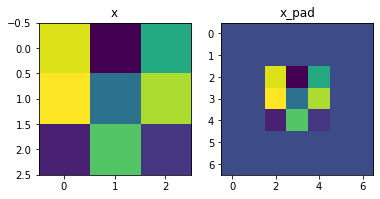

In [4]:
np.random.seed(1)
x = np.random.randn(4, 3, 3, 2)
x_pad = zero_pad(x, 2)
assert_equal(x.shape,(4, 3, 3, 2))
assert_equal(x_pad.shape,(4, 7, 7, 2))
assert_allclose(x_pad[1,1],[[0., 0.],[0., 0.], [0., 0.],[0. ,0.], [0. ,0.],[0., 0.], [0., 0.]])
fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('x')
axarr[0].imshow(x[0,:,:,0])
axarr[1].set_title('x_pad')
axarr[1].imshow(x_pad[0,:,:,0])
print ("all is correct !")

## Convolution layer

The principle of the convolution layer is illustrated on the following animation

<img src="https://kermorvant.github.io/ml/images/conv_NN.gif" style="width:600px;">

We will decompose the task in the following steps : 
1. `conv_single_step`: compute a single convolution step : this correspond to the computation of 1 value in one dimension in the output volume. It consider all the dimension of the previous layer and compute the convolution with the kernel. Note that the kernel has the same "depth" as the previous layer but all the values are summed.
2. `conv_forward`: apply the single convolution step at each position and as many times as the depth of the output layer. 

### Single convolution step

First, we implement a single convolution step : 

In [5]:
def conv_single_step(a_slice_prev, W, b):
    """
    Apply one filter defined by parameters W on a single slice (a_slice_prev) of the output activation 
    of the previous layer.
    
    params: a_slice_prev: slice of input data of shape (f, f, n_C_prev)
    params: W: convolution weights  of shape (f, f, n_C_prev)
    params: b: bias weights of shape (1, 1, 1)
    
    returns: Z:  a scalar value, result of convolving the sliding window (W, b) on a slice x of the input data
    """

    # Element-wise product between a_slice and W
    s = np.multiply(a_slice_prev,W)
    print (s)
    # Sum over all entries of the volume s.
    Z = np.sum(s)
    print (Z)
    print (b)
    # Add bias b to Z. Cast b to a float() so that Z results in a scalar value.
    Z = np.add (Z,float(b))

    return Z

In [6]:
np.random.seed(1)
a_slice_prev = np.random.randn(4, 4, 3)
W = np.random.randn(4, 4, 3)
b = np.random.randn(1, 1, 1)
Z = conv_single_step(a_slice_prev, W, b)
assert_almost_equal (Z,-6.99908945068)
print ("all is correct !")

[[[ 0.19517964 -0.37757796 -0.15854148]
  [ 0.37795303 -0.98874397  0.80402579]
  [-0.36448112 -0.44654162  0.26766851]
  [-0.23218928  0.41755949 -1.82351535]]

 [[ 0.24323087 -0.48116947  0.58154416]
  [ 0.32786971 -0.08423431  0.06634126]
  [ 0.04777032  0.88577236 -2.40548621]
  [-1.59860247 -1.30199961 -0.25349124]]

 [[ 0.14417035 -0.5990611  -0.03878845]
  [ 1.89231409  0.0820284   0.43912088]
  [-0.1591475  -0.30233062  0.15277783]
  [ 0.16968185 -0.12522861 -0.00519314]]

 [[-0.22156233  0.02789749 -1.11316672]
  [ 0.280169   -0.02336965 -1.00256263]
  [-0.89578144  0.31336883 -0.01906739]
  [ 0.40686849  0.08085163  0.16243388]]]
-6.655235775109145
[[[-0.34385368]]]
all is correct !


### Apply convolution at multiple positions

To apply the convolution at each position, you need to compute the dimensions of the output  layer. The dimensions are given by the following formula : 

The formulas relating the output shape of the convolution to the input shape is:
$$ n_H = \lfloor \frac{n_{H_{prev}} - f + 2 \times pad}{stride} \rfloor +1 $$
$$ n_W = \lfloor \frac{n_{W_{prev}} - f + 2 \times pad}{stride} \rfloor +1 $$
$$ n_C = \text{number of filters used in the convolution}$$

Then you will need to locate the region of the image on which the convolution kernel is applied : 

<img src="https://kermorvant.github.io/ml/images/cnn_vert_horiz_boundaries.png" style="width:350px;">

In [7]:
def conv_forward(A_prev, W, b, hparameters):
    """
    Implements the forward propagation for a convolution function
    
    params: A_prev:  output activations of the previous layer of shape (m, n_H_prev, n_W_prev, n_C_prev)
    params: W: convolution weights  of shape (f, f, n_C_prev, n_C)
    params: bias: weights of shape  (1, 1, 1, n_C)
    params: hparameters: python dictionary containing "stride" and "pad"
        
    returns: Z:  conv output of shape (m, n_H, n_W, n_C)
    cache:  cache of values needed for the conv_backward() function
    """
    

    # Retrieve dimensions from A_prev's shape 
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Retrieve dimensions from W's shape 
    (f, f, n_C_prev, n_C) = W.shape
    
    # Retrieve information from "hparameters" 
    stride = hparameters['stride']
    pad = hparameters['pad']
    
    # Compute the dimensions of the CONV output volume using the formula given above. 
    n_H = int((n_H_prev+2*pad-f)/2.0+1)
    n_W = int((n_W_prev+2*pad-f)/2.0+1)

    # Initialize the output volume Z with zeros. 
    Z = np.zeros((m,n_H,n_W,n_C))
    
    # Create A_prev_pad by padding A_prev
    A_prev_pad = zero_pad(A_prev,pad)
    
    # loop over the batch of training examples
    for i in range(m):                
        # Select ith training example's padded activation
        a_prev_pad = A_prev_pad[i,:,:,:]             
        # loop over vertical axis of the output volume
        for h in range(n_H): 
            # loop over horizontal axis of the output volume
            for w in range(n_W):                     
                # Find the corners of the current "slice"             
                vert_start = h*stride
                vert_end = vert_start+f
                horiz_start = w*stride
                horiz_end = horiz_start+f
                for c in range(n_C):   
                    # loop over channels (= #filters) of the output volume
                    # Use the corners to define the (3D) slice of a_prev_pad 
                    a_slice_prev = a_prev_pad[vert_start:vert_end,horiz_start:horiz_end,:]
                    # Convolve the (3D) slice with the correct filter W and bias b, to get back one output neuron.
                    Z[i, h, w, c] = conv_single_step(a_slice_prev,W[:,:,:,c],b[:,:,:,c])
                                        
    # dimension check
    assert(Z.shape == (m, n_H, n_W, n_C))
    # Save information in "cache" for the backprop
    cache = (A_prev, W, b, hparameters)
    
    return Z, cache

In [8]:

np.random.seed(1)
A_prev = np.random.randn(10,4,4,3)
W = np.random.randn(2,2,3,8)
b = np.random.randn(1,1,1,8)
hparameters = {"pad" : 2,"stride": 2}
Z, cache_conv = conv_forward(A_prev, W, b, hparameters)
assert_almost_equal(np.mean(Z),0.0489952035289)
assert_allclose(Z[3,2,1],[-0.61490741 ,-6.7439236 ,-2.55153897 ,1.75698377, 3.56208902, 0.53036437, 5.18531798 ,8.75898442])
assert_allclose(cache_conv[0][1][2][3],[-0.20075807, 0.18656139, 0.41005165])
print ("all is correct !")

[[[ 0.  0.  0.]
  [-0.  0.  0.]]

 [[ 0.  0. -0.]
  [ 0.  0. -0.]]]
0.0
[[[0.37245685]]]
[[[-0. -0. -0.]
  [ 0. -0. -0.]]

 [[ 0. -0. -0.]
  [-0. -0.  0.]]]
0.0
[[[-0.1484898]]]
[[[-0. -0. -0.]
  [-0.  0.  0.]]

 [[ 0. -0. -0.]
  [-0.  0. -0.]]]
0.0
[[[-0.1834002]]]
[[[ 0.  0. -0.]
  [ 0. -0.  0.]]

 [[-0.  0.  0.]
  [ 0.  0.  0.]]]
0.0
[[[1.1010002]]]
[[[ 0. -0. -0.]
  [-0. -0.  0.]]

 [[-0. -0.  0.]
  [-0. -0.  0.]]]
0.0
[[[0.78002714]]]
[[[ 0.  0.  0.]
  [ 0.  0.  0.]]

 [[ 0. -0. -0.]
  [ 0.  0.  0.]]]
0.0
[[[-0.6294416]]]
[[[ 0. -0. -0.]
  [ 0.  0.  0.]]

 [[-0. -0. -0.]
  [-0.  0.  0.]]]
0.0
[[[-1.1134361]]]
[[[ 0. -0. -0.]
  [ 0.  0. -0.]]

 [[-0.  0. -0.]
  [ 0.  0.  0.]]]
0.0
[[[-0.06741002]]]
[[[ 0.  0.  0.]
  [-0.  0.  0.]]

 [[ 0.  0. -0.]
  [ 0.  0. -0.]]]
0.0
[[[0.37245685]]]
[[[-0. -0. -0.]
  [ 0. -0. -0.]]

 [[ 0. -0. -0.]
  [-0. -0.  0.]]]
0.0
[[[-0.1484898]]]
[[[-0. -0. -0.]
  [-0.  0.  0.]]

 [[ 0. -0. -0.]
  [-0.  0. -0.]]]
0.0
[[[-0.1834002]]]
[[[ 0.  0. -0.]
  [ 0

  [ 1.33588136 -0.06053928 -0.39779951]]]
0.655983568469671
[[[1.1010002]]]
[[[ 3.20037654  0.78669945  1.11230498]
  [-0.54193498 -2.04502916 -0.24031527]]

 [[ 0.32027022 -0.13309875  0.65902412]
  [-0.28763158  0.18085144 -0.22945514]]]
2.782061880360998
[[[0.78002714]]]
[[[ 1.29793001 -0.8570528  -0.03695253]
  [ 0.50129298  1.4093885  -0.17728879]]

 [[-0.48702755 -0.22936987 -0.58116972]
  [ 1.90124941 -0.4372159  -1.14397776]]]
1.1598059744714773
[[[-0.6294416]]]
[[[ 2.6240877   2.99465027  0.51724061]
  [ 1.52694671  0.45772491 -0.32476825]]

 [[ 0.3677661  -0.49093363 -0.08938182]
  [-1.12511715 -0.07164076 -0.0878206 ]]]
6.298754087931543
[[[-1.1134361]]]
[[[ 3.73425399  1.57137772  0.18863741]
  [ 0.17747553  2.79930015  0.15032532]]

 [[ 0.49860919  0.31788172 -0.76003871]
  [ 0.47744667 -0.01185575 -0.3170188 ]]]
8.82639444368906
[[[-0.06741002]]]
[[[ 0.0225076  -0.23538699  0.7041807 ]
  [ 0.07440781  0.11552296 -0.46143435]]

 [[ 0.35824438  0.16466449 -0.62507274]
  [-0

0.0
[[[1.1010002]]]
[[[ 0. -0. -0.]
  [-0. -0.  0.]]

 [[-0. -0.  0.]
  [-0. -0.  0.]]]
0.0
[[[0.78002714]]]
[[[ 0.  0.  0.]
  [ 0.  0.  0.]]

 [[ 0. -0. -0.]
  [ 0.  0.  0.]]]
0.0
[[[-0.6294416]]]
[[[ 0. -0. -0.]
  [ 0.  0.  0.]]

 [[-0. -0. -0.]
  [-0.  0.  0.]]]
0.0
[[[-1.1134361]]]
[[[ 0. -0. -0.]
  [ 0.  0. -0.]]

 [[-0.  0. -0.]
  [ 0.  0.  0.]]]
0.0
[[[-0.06741002]]]
[[[ 0.  0.  0.]
  [-0.  0.  0.]]

 [[ 0.  0. -0.]
  [ 0.  0. -0.]]]
0.0
[[[0.37245685]]]
[[[-0. -0. -0.]
  [ 0. -0. -0.]]

 [[ 0. -0. -0.]
  [-0. -0.  0.]]]
0.0
[[[-0.1484898]]]
[[[-0. -0. -0.]
  [-0.  0.  0.]]

 [[ 0. -0. -0.]
  [-0.  0. -0.]]]
0.0
[[[-0.1834002]]]
[[[ 0.  0. -0.]
  [ 0. -0.  0.]]

 [[-0.  0.  0.]
  [ 0.  0.  0.]]]
0.0
[[[1.1010002]]]
[[[ 0. -0. -0.]
  [-0. -0.  0.]]

 [[-0. -0.  0.]
  [-0. -0.  0.]]]
0.0
[[[0.78002714]]]
[[[ 0.  0.  0.]
  [ 0.  0.  0.]]

 [[ 0. -0. -0.]
  [ 0.  0.  0.]]]
0.0
[[[-0.6294416]]]
[[[ 0. -0. -0.]
  [ 0.  0.  0.]]

 [[-0. -0. -0.]
  [-0.  0.  0.]]]
0.0
[[[-1.1134361]]]
[

[[[ 0.34745357 -1.75354118 -0.01035895]
  [ 0.02908299 -0.0165735  -0.8250605 ]]

 [[ 1.41560059  0.2586447   1.04793542]
  [ 0.03652641 -0.8434581  -0.2886029 ]]]
-0.6023514623506665
[[[1.1010002]]]
[[[ 0.75246712  1.1543258  -1.00523815]
  [-0.19493967 -0.01768369 -0.45299164]]

 [[ 0.44192119 -0.30342303  1.11679155]
  [-0.00786458  2.51969637 -0.16646933]]]
3.8365919349891824
[[[0.78002714]]]
[[[ 0.30516711 -1.25755543  0.0333956 ]
  [ 0.18032032  0.01218721 -0.33418742]]

 [[-0.67201939 -0.52289074 -0.98485838]
  [ 0.05198501 -6.0914711  -0.82995403]]]
-10.109881241103222
[[[-0.6294416]]]
[[[ 6.16971060e-01  4.39405679e+00 -4.67452730e-01]
  [ 5.49258669e-01  3.95802049e-03 -6.12184581e-01]]

 [[ 5.07457845e-01 -1.11917334e+00 -1.51467695e-01]
  [-3.07635752e-02 -9.98128458e-01 -6.37137048e-02]]]
2.6288183002624366
[[[-1.1134361]]]
[[[ 0.87799148  2.30568591 -0.17047979]
  [ 0.0638398   0.024206    0.28336158]]

 [[ 0.68800018  0.72466975 -1.28797229]
  [ 0.01305461 -0.16517914 -0

## Pooling layer

The second kind of layer often used in deep convolution neural networks is the max pooling layer. Other kind of pooling exists (max, average, L2), but we will focus on max pooling.

The compution of a ma pooling layer with size f=2 and stride=2 is given below : 

<img src="https://kermorvant.github.io/ml/images/cnn_max_pooling.png" style="width:350px;">


Since the single operation is a simple max over values and that the skeleton is similar to that of the convolution, we will directly implement the application of max pooling at mutliple position.


In [9]:
def pool_forward(A_prev, hparameters, mode = "max"):
    """
    Implements the forward pass of the pooling layer
    
    Arguments:
    params: A_prev: input data, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    params: hparameters:  dictionary containing "f" and "stride"
    
    
    returns: A:  output of the pool layer  of shape (m, n_H, n_W, n_C)
    cache: cache used in the backward pass of the pooling layer, contains the input and hparameters 
    """
    
    # Retrieve dimensions from the input shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Retrieve hyperparameters from "hparameters"
    f = hparameters["f"]
    stride = hparameters["stride"]
    
    # Define the dimensions of the output
    n_H = int(1 + (n_H_prev - f) / stride)
    n_W = int(1 + (n_W_prev - f) / stride)
    n_C = n_C_prev
    
    # Initialize output matrix A
    A = np.zeros((m, n_H, n_W, n_C))              
    
    # loop over the training examples
    for i in range(m):         
        # loop on the vertical axis of the output volume
        for h in range(n_H):      
            # loop on the horizontal axis of the output volume
            for w in range(n_W):   
                # loop over the channels of the output volume
                for c in range (n_C):            
                    
                    # Find the boundaries of the current "slice" 
                    vert_start = h*stride
                    vert_end = vert_start+f
                    horiz_start = w*stride
                    horiz_end = horiz_start+f
                    
                    # Use the boundaries to define the current slice on the ith training example of A_prev, channel c. 
                    a_prev_slice = A_prev[i,vert_start:vert_end,horiz_start:horiz_end,c]
                    
                    # Compute the max pooling operation on the slice. 
                    A[i, h, w, c] = np.max(a_prev_slice)
                    
    # Store the input and hparameters in "cache" for pool_backward()
    cache = (A_prev, hparameters)
    
    # Making sure your output shape is correct
    assert(A.shape == (m, n_H, n_W, n_C))
    
    return A, cache

In [10]:
np.random.seed(1)
A_prev = np.random.randn(2, 4, 4, 3)
hparameters = {"stride" : 2, "f": 3}
A, cache = pool_forward(A_prev, hparameters)
assert_allclose(A,[[[[ 1.74481176, 0.86540763 ,1.13376944]]] ,[[[ 1.13162939, 1.51981682, 2.18557541]]]])
print ("all is correct !")

all is correct !


You now know precisely the details of the convolution and max pooling layers.